In [6]:
import random
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm
import haversine as hs

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import norm
from torch_geometric.data import Data

# y_true, y_pred
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

from scipy import spatial

torch.manual_seed(12345)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

%matplotlib inline

# https://stackoverflow.com/questions/70452465/how-to-load-in-graph-from-networkx-into-pytorch-geometric-and-set-node-features

# Selected features and read the dataset

In [7]:
features = ['accommodates', 'latitude', 'longitude',
            'number_of_reviews', 'calculated_host_listings_count', 'bedrooms',
           'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [8]:
listings_df = pd.read_csv('santorini_listings.csv')
listings_df['price_log'] = np.log(listings_df['price'])

listings_df.fillna(0, inplace=True)

In [9]:
#listings_df = listings_df[:200]

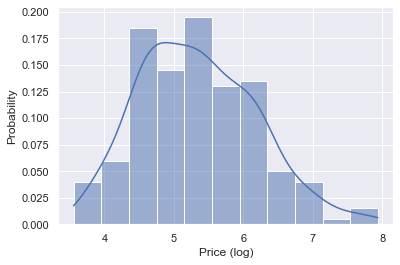

In [10]:
fig = sns.histplot(data=listings_df, x='price_log', kde=True, stat='probability')
fig.set_xlabel('Price (log)')
fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

# Generate doc2vec embeddings from the descriptions of the listings.

In [12]:
documents = [document.split(' ') if type(document) is str else [] for document in listings_df.description.values]
document_embeddings = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]
model = Doc2Vec(document_embeddings, vector_size=100, window=3, min_count=2, workers=4)
fname = get_tmpfile("doc2vec_model")
model.save(fname)

In [13]:
doc_inference = {}
for i, document in enumerate(tqdm(documents)):
    doc_inference[i] = model.infer_vector(document).tolist()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 851.00it/s]


# Generate the graph of listings.

In [14]:
G = nx.Graph()
distance_threshold_in_meters = 200
document_similarity_threshold = 0.95
edges = set()
for i, rowi in enumerate(tqdm(listings_df.itertuples(), total=listings_df.shape[0])):
    for j, rowj in enumerate(listings_df.itertuples()):
        idi = rowi.id
        idj = rowj.id
        doc_embedding_i = doc_inference[i]
        doc_embedding_j = doc_inference[j]
        G.add_nodes_from([
            (idi, {'y': [rowi.price_log], 'x': [getattr(rowi, feature) for feature in features] + doc_embedding_i}),
            (idj, {'y': [rowj.price_log], 'x': [getattr(rowj, feature) for feature in features] + doc_embedding_j})
        ])
        
        distance = hs.haversine((rowi.latitude, rowi.longitude), (rowj.latitude, rowj.longitude), unit='m')
        cosine_document_similarity = spatial.distance.cosine(doc_embedding_i, doc_embedding_j)
        if distance > distance_threshold_in_meters or cosine_document_similarity < document_similarity_threshold:
        #if distance > distance_threshold_in_meters:
            continue
        fst = np.min([idi, idj])
        snd = np.max([idi, idj])
        edge_key = f'{fst}-{snd}'
        if edge_key in edges:
            continue
        edges.add(edge_key)
        G.add_edges_from([(fst, snd, {'weight': distance})])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.31it/s]


### Statistics of the graph

In [15]:
print('number of node attributes %s' % len(nx.get_node_attributes(G, 'x')[13131]))
print('number of edges %s' % G.size())
print('number of nodes %s' % (len(G)))
x = G.degree()
x = list(dict(x).values())
print('average degree %s' % (sum(x)/len(x)))

number of node attributes 114
number of edges 0
number of nodes 200
average degree 0.0


In [16]:
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

# Split the data into train and test sets

In [17]:
# Split the data 
train_ratio = 0.67
num_nodes = pyg_graph.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

random.Random(5).shuffle(idx)

train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

dataset = pyg_graph

## Our model - GCNBnB

In [18]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.normalizer = norm.BatchNorm(dataset.num_node_features)
        self.conv1 = GCNConv(dataset.num_node_features, 100)
        self.linear1 = torch.nn.Linear(100, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.normalizer(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epoch_loss = []
model.train()
for epoch in range(200):
    optimizer.step()
    out = model(data)
    loss = F.l1_loss(out[train_mask].squeeze(), data.y[train_mask].squeeze())
    optimizer.zero_grad()
    loss.backward()
    print('epoch {}, loss function {}'.format(epoch, loss.item()))
    epoch_loss.append(loss.item())

epoch 0, loss function 5.572031497955322
epoch 1, loss function 4.060911178588867
epoch 2, loss function 2.8270013332366943
epoch 3, loss function 2.8897807598114014
epoch 4, loss function 3.166910171508789
epoch 5, loss function 2.948481798171997
epoch 6, loss function 2.519646167755127
epoch 7, loss function 2.443653106689453
epoch 8, loss function 2.5422003269195557
epoch 9, loss function 2.5123326778411865
epoch 10, loss function 2.2710225582122803
epoch 11, loss function 2.1242129802703857
epoch 12, loss function 2.121514081954956
epoch 13, loss function 2.071000337600708
epoch 14, loss function 1.9382492303848267
epoch 15, loss function 1.808683156967163
epoch 16, loss function 1.676370620727539
epoch 17, loss function 1.568138837814331
epoch 18, loss function 1.480207085609436
epoch 19, loss function 1.3467274904251099
epoch 20, loss function 1.1788036823272705
epoch 21, loss function 1.1349807977676392
epoch 22, loss function 1.0897715091705322
epoch 23, loss function 0.9195923

epoch 199, loss function 0.15834620594978333


In [20]:
with torch.no_grad():
    model.eval()
    pred = model(data)
    y_true = data.y[test_mask].tolist()
    y_pred = pred[test_mask].tolist()
    print('r2:%s' % r2_score(y_true, y_pred))
    print('mse:%s' % mean_squared_error(y_true, y_pred))

r2:0.260792114812177
mse:0.3895061133708721


## Baselines

### Neural network

In [21]:
data = Data(x=dataset.x, y=dataset.y)
data = data.to(device)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        torch.manual_seed(12345)
        self.normalizer = nn.LayerNorm(data.x.shape[1])
        self.linear1 = torch.nn.Linear(data.x.shape[1], 100)
        self.linear2 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.normalizer(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        
        return x

# Initialize the MLP
mlp = MLP().to(device)


mlp.train()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=5e-4)
  
# Run the training loop
for epoch in range(0, 1000):
    # Get and prepare inputs
    inputs, targets = data.x[idx[:num_train]], data.y[train_mask].squeeze()
      
    # Zero the gradients
    optimizer.zero_grad()
      
    # Perform forward pass
    outputs = mlp(inputs).squeeze()
      
    # Compute loss
    loss = loss_function(outputs.squeeze(), targets)
      
    # Perform backward pass
    loss.backward()
      
    # Perform optimization
    optimizer.step()

    
    print('epoch {}, loss function {}'.format(epoch, loss.item()))

# Process is complete.
print('Training process has finished.')

epoch 0, loss function 5.55695104598999
epoch 1, loss function 5.498366832733154
epoch 2, loss function 5.514894485473633
epoch 3, loss function 5.490368843078613
epoch 4, loss function 5.505905628204346
epoch 5, loss function 5.454981327056885
epoch 6, loss function 5.479246139526367
epoch 7, loss function 5.472354412078857
epoch 8, loss function 5.476804256439209
epoch 9, loss function 5.430298328399658
epoch 10, loss function 5.421919822692871
epoch 11, loss function 5.402451992034912
epoch 12, loss function 5.39597749710083
epoch 13, loss function 5.366254806518555
epoch 14, loss function 5.363675117492676
epoch 15, loss function 5.339900016784668
epoch 16, loss function 5.347176551818848
epoch 17, loss function 5.32861328125
epoch 18, loss function 5.282236576080322
epoch 19, loss function 5.3147382736206055
epoch 20, loss function 5.301897048950195
epoch 21, loss function 5.218520164489746
epoch 22, loss function 5.241352081298828
epoch 23, loss function 5.254899978637695
epoch 2

epoch 231, loss function 1.463745355606079
epoch 232, loss function 1.4348877668380737
epoch 233, loss function 1.403346061706543
epoch 234, loss function 1.3285441398620605
epoch 235, loss function 1.4814709424972534
epoch 236, loss function 1.4649972915649414
epoch 237, loss function 1.42586088180542
epoch 238, loss function 1.4068478345870972
epoch 239, loss function 1.3931119441986084
epoch 240, loss function 1.406333565711975
epoch 241, loss function 1.3971227407455444
epoch 242, loss function 1.3322912454605103
epoch 243, loss function 1.3820196390151978
epoch 244, loss function 1.3049616813659668
epoch 245, loss function 1.2024964094161987
epoch 246, loss function 1.3229708671569824
epoch 247, loss function 1.2551497220993042
epoch 248, loss function 1.2654451131820679
epoch 249, loss function 1.2572749853134155
epoch 250, loss function 1.25473153591156
epoch 251, loss function 1.1989994049072266
epoch 252, loss function 1.2734804153442383
epoch 253, loss function 1.372271895408

epoch 463, loss function 1.1014989614486694
epoch 464, loss function 1.176023006439209
epoch 465, loss function 1.1591365337371826
epoch 466, loss function 1.189505696296692
epoch 467, loss function 1.2236263751983643
epoch 468, loss function 1.154327630996704
epoch 469, loss function 1.1236283779144287
epoch 470, loss function 1.239477515220642
epoch 471, loss function 1.1193597316741943
epoch 472, loss function 1.2322899103164673
epoch 473, loss function 1.0615947246551514
epoch 474, loss function 1.1825408935546875
epoch 475, loss function 1.250105619430542
epoch 476, loss function 1.1990346908569336
epoch 477, loss function 1.127458930015564
epoch 478, loss function 1.2480144500732422
epoch 479, loss function 1.1176600456237793
epoch 480, loss function 1.0850247144699097
epoch 481, loss function 1.2557475566864014
epoch 482, loss function 1.1320182085037231
epoch 483, loss function 1.255759358406067
epoch 484, loss function 1.1723523139953613
epoch 485, loss function 1.203905701637

epoch 702, loss function 1.0085690021514893
epoch 703, loss function 1.0572457313537598
epoch 704, loss function 1.1227542161941528
epoch 705, loss function 1.1052517890930176
epoch 706, loss function 1.1786773204803467
epoch 707, loss function 1.1275511980056763
epoch 708, loss function 1.106724500656128
epoch 709, loss function 1.0855165719985962
epoch 710, loss function 1.1221524477005005
epoch 711, loss function 1.0249066352844238
epoch 712, loss function 1.056662678718567
epoch 713, loss function 1.148978352546692
epoch 714, loss function 1.0630288124084473
epoch 715, loss function 1.0571041107177734
epoch 716, loss function 1.1363708972930908
epoch 717, loss function 1.1474361419677734
epoch 718, loss function 1.0011937618255615
epoch 719, loss function 1.1658605337142944
epoch 720, loss function 1.1641089916229248
epoch 721, loss function 1.1608881950378418
epoch 722, loss function 1.17071533203125
epoch 723, loss function 1.0576753616333008
epoch 724, loss function 1.1604595184

epoch 940, loss function 1.0773526430130005
epoch 941, loss function 1.1119272708892822
epoch 942, loss function 1.0246869325637817
epoch 943, loss function 1.1467173099517822
epoch 944, loss function 1.017823338508606
epoch 945, loss function 0.9500565528869629
epoch 946, loss function 1.0967106819152832
epoch 947, loss function 1.044886827468872
epoch 948, loss function 1.174060344696045
epoch 949, loss function 1.081032633781433
epoch 950, loss function 1.0706204175949097
epoch 951, loss function 0.96892249584198
epoch 952, loss function 1.139272689819336
epoch 953, loss function 1.0480012893676758
epoch 954, loss function 1.0638163089752197
epoch 955, loss function 1.0826829671859741
epoch 956, loss function 1.0866355895996094
epoch 957, loss function 1.108311414718628
epoch 958, loss function 1.0649943351745605
epoch 959, loss function 1.1015756130218506
epoch 960, loss function 1.0824897289276123
epoch 961, loss function 1.0854432582855225
epoch 962, loss function 1.0928975343704

In [22]:
with torch.no_grad():
    mlp.eval()
    pred = mlp(data.x[idx[num_train:]])
    y_true = data.y[test_mask].squeeze().tolist()
    y_pred = pred.squeeze().tolist()
    print('r2:%s' % r2_score(y_true, y_pred))
    print('mse:%s' % mean_squared_error(y_true, y_pred))

r2:-0.4178051938050149
mse:0.7470750808018093


In [23]:
# Prepare the data for the rest of the baselines.

In [24]:
x_train, y_train = data.x[idx[:num_train]].tolist(), data.y[train_mask].squeeze().tolist()
scaler = MinMaxScaler()
x_test, y_test = data.x[idx[num_train:]].tolist(), data.y[test_mask].squeeze().tolist()
scaler.fit(x_test)

MinMaxScaler()

### Linear regression

In [25]:
reg = LinearRegression()
reg.fit(scaler.transform(x_train), y_train)
print('r2:%s' % reg.score(scaler.transform(x_test), y_test))
print('mse:%s' % mean_squared_error(y_true, reg.predict(scaler.transform(x_test))))

r2:-8.081695653207058
mse:4.785360177535206


### Random forest

In [26]:
reg = RandomForestRegressor(max_depth=5, random_state=42)
reg.fit(scaler.fit_transform(x_train), y_train)
print('r2:%s' % reg.score(scaler.transform(x_test), y_test))
print('mse:%s' % mean_squared_error(y_true, reg.predict(scaler.transform(x_test))))

r2:-0.2427040152124984
mse:0.65481012951155


### Decision tree

In [27]:
reg = DecisionTreeRegressor(max_depth=5, random_state=42)
reg.fit(scaler.fit_transform(x_train), y_train)
print('r2:%s' % reg.score(scaler.transform(x_test), y_test))
print('mse:%s' % mean_squared_error(y_true, reg.predict(scaler.transform(x_test))))

r2:-0.9752265271142317
mse:1.0407935616214714
